## Construct UMAP supplementary figure

- Supplementary Figure 2 - UMAP of the same feature spaces, separated by phenotype

**Note:** We create the main UMAP figure in a different notebook

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
source("themes.r")

In [2]:
figure_dir <- "figures"
sup_figure_dir <- file.path(figure_dir, "supplementary")

output_supplementary_umap_figure <- file.path(sup_figure_dir, "supplementary_umap.png")

In [3]:
# Load UMAP coordinates and process
umap_dir <- file.path("../../mitocheck_data/4.analyze_data/results/")
umap_file <- file.path(umap_dir, "compiled_2D_umap_embeddings.csv")

umap_df <- readr::read_csv(
    umap_file,
    col_types = readr::cols(
        .default = "c",
        Embedding_Value = "d"
    )
) %>%
    dplyr::select(!...1) %>%
    dplyr::filter(Mitocheck_Phenotypic_Class != "Folded") %>%  # Drop folded class due to low n
    tidyr::pivot_wider(names_from = UMAP_Embedding, values_from = Embedding_Value) %>%
    dplyr::mutate(Mitocheck_Plot_Label = if_else(
        Mitocheck_Phenotypic_Class %in% focus_phenotypes,
        Mitocheck_Phenotypic_Class,
        "Other"
    ))

umap_df$Mitocheck_Plot_Label <-
    dplyr::recode_factor(umap_df$Mitocheck_Plot_Label, !!!focus_phenotype_labels)

umap_df$Feature_Type <-
    dplyr::recode_factor(umap_df$Feature_Type, !!!facet_labels)

head(umap_df)

New names:
• `` -> `...1`


Mitocheck_Phenotypic_Class,Feature_Type,Cell_UUID,UMAP1,UMAP2,Mitocheck_Plot_Label
<chr>,<fct>,<chr>,<dbl>,<dbl>,<fct>
Large,CellProfiler,21da27ab-873a-41f4-ab98-49170cae9a2d,6.878828,5.770409,Large
Large,CellProfiler,82f7949b-4ea2-45c8-8dd9-7854caf49077,9.861546,3.066624,Large
Large,CellProfiler,cec7234f-fe35-4411-aded-f8112bb31219,6.802670,5.958431,Large
Large,CellProfiler,43d9e7c9-c9ec-45ce-8820-048bfb896989,8.546513,6.359310,Large
Large,CellProfiler,63ce6652-338e-4afd-9c77-dbc0e903bf92,8.440182,6.067466,Large
Large,CellProfiler,08c1dd64-a50a-470a-8fac-3df28fd3b825,10.021554,2.915943,Large


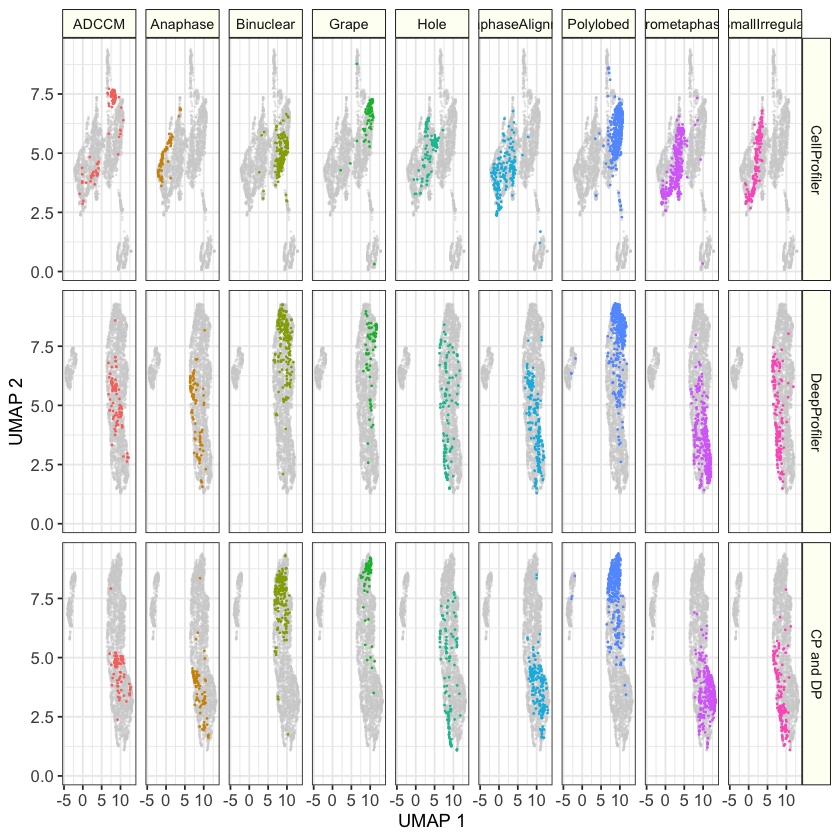

In [4]:
umap_other_df <- umap_df %>%
    dplyr::filter(!Mitocheck_Phenotypic_Class %in% focus_phenotypes)

# Custom function for name repair
name_repair_function <- function(names) {
  names[1] <- paste0(names[1], "_original")
  return(names)
}

df_background <- tidyr::crossing(
    umap_df,
    Mitocheck_Phenotypic_Class = unique(umap_other_df$Mitocheck_Phenotypic_Class),
    .name_repair = name_repair_function
)

umap_sup_fig_other_gg <- (
    ggplot(
        umap_other_df,
        aes(x = UMAP1, y = UMAP2)
    )
    + geom_point(
        data = df_background,
        color = "lightgray",
        size = 0.1,
        alpha = 0.4
    )
    + geom_point(
        aes(color = Mitocheck_Phenotypic_Class),
        size = 0.1
    )
    + facet_grid("Feature_Type~Mitocheck_Phenotypic_Class")
    + theme_bw()
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "UMAP 1", y = "UMAP 2")
    + theme(
        legend.position = "none",
        strip.text = element_text(size = 8.5),
    )
)

ggsave(output_supplementary_umap_figure, dpi = 500, height = 5, width = 13)

umap_sup_fig_other_gg